
Epoch 1/15


Evaluating: 100%|██████████| 225/225 [00:33<00:00,  6.67it/s]


Train Loss: 0.6034 | Val Loss: 0.5674 | Val Acc: 0.7000 | Val F1: 0.6738

Epoch 2/15


Evaluating: 100%|██████████| 225/225 [00:24<00:00,  9.13it/s]


Train Loss: 0.5651 | Val Loss: 0.5591 | Val Acc: 0.6972 | Val F1: 0.6805

Epoch 3/15


Evaluating: 100%|██████████| 225/225 [00:24<00:00,  9.12it/s]


Train Loss: 0.5702 | Val Loss: 0.5664 | Val Acc: 0.6928 | Val F1: 0.6696

Epoch 4/15


Evaluating: 100%|██████████| 225/225 [00:24<00:00,  9.16it/s]


Train Loss: 0.5559 | Val Loss: 0.5758 | Val Acc: 0.7033 | Val F1: 0.6772

Epoch 5/15


Evaluating: 100%|██████████| 225/225 [00:24<00:00,  9.02it/s]


Train Loss: 0.5583 | Val Loss: 0.5598 | Val Acc: 0.7100 | Val F1: 0.7063
Early stopping triggered.

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.90      0.79      1132
           1       0.68      0.37      0.48       668

    accuracy                           0.70      1800
   macro avg       0.70      0.64      0.64      1800
weighted avg       0.70      0.70      0.68      1800



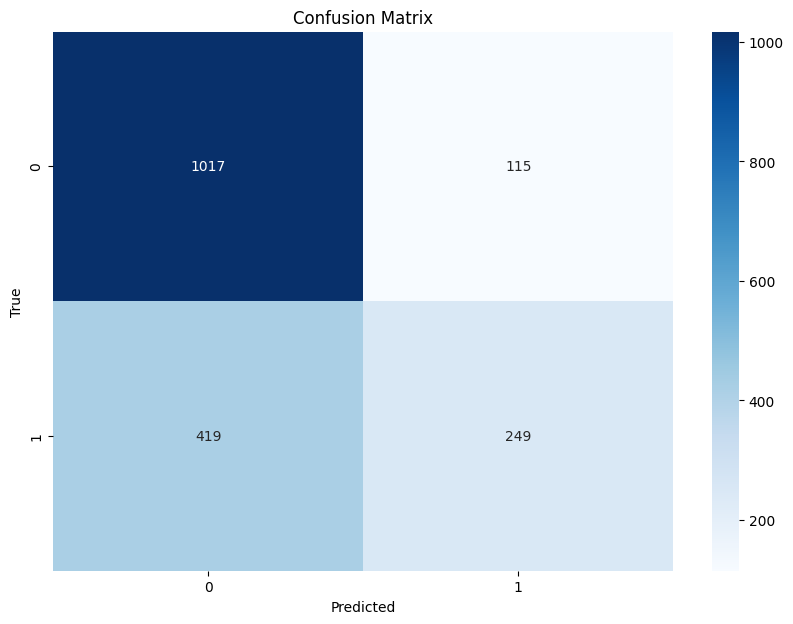

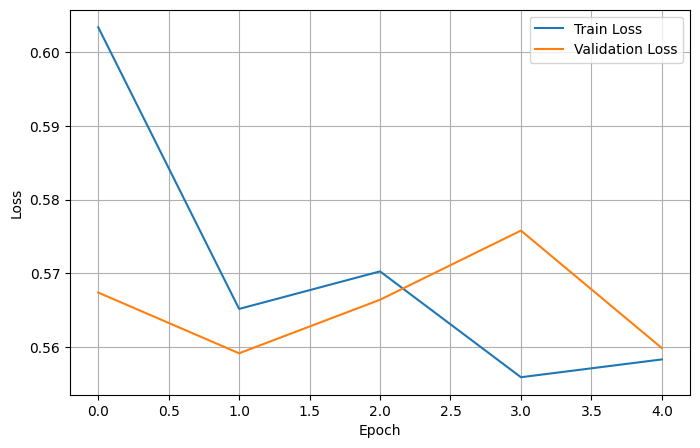

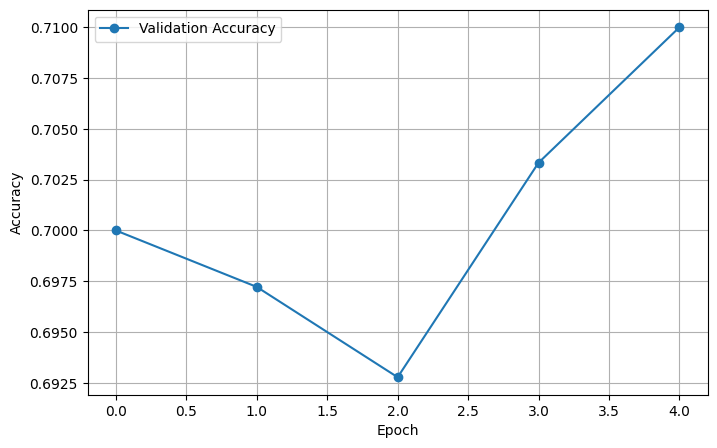

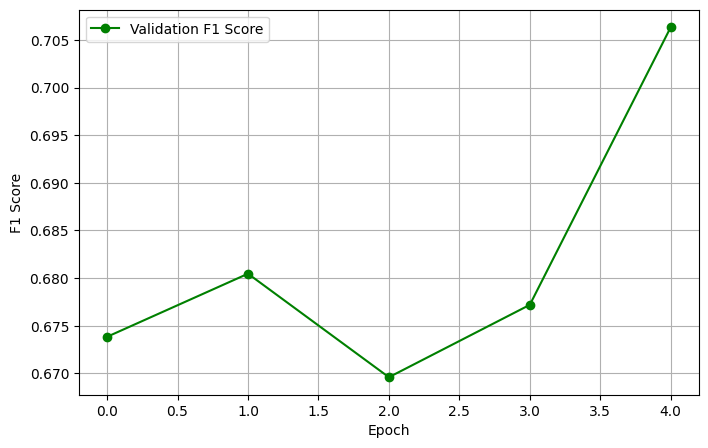

In [ ]:
# ====================== Imports ======================
import os
import json
import torch
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from transformers import SiglipProcessor, SiglipVisionModel
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# ====================== CONFIG ======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_DIR = "data/img"
JSONL_PATH = "data/dataset.jsonl"
NUM_LABELS = 2
LABEL_MAP = {0: 'non-hateful', 1: 'hateful'}
INV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}
BATCH_SIZE = 8
EPOCHS = 15

# ====================== Load JSONL with validation ======================
records = []
with open(JSONL_PATH, "r", encoding="utf-8") as f:
    for line in f:
        try:
            data = json.loads(line.strip())
            if all(k in data for k in ['label', 'img']):
                records.append(data)
        except json.JSONDecodeError:
            continue

# ====================== Dataset ======================
class MemeDataset(Dataset):
    def __init__(self, records, processor, img_dir):
        self.data = records
        self.processor = processor
        self.img_dir = img_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data[idx]
        image_path = os.path.join(self.img_dir, os.path.basename(row['img']))

        image = Image.open(image_path).convert("RGB")
        label = row['label']

        inputs = self.processor(
            images=image,
            return_tensors="pt"
        )

        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        inputs["labels"] = torch.tensor(label, dtype=torch.long)
        return inputs

# ====================== Model ======================
class SigLIPClassificationHead(nn.Module):
    def __init__(self, num_labels):
        super().__init__()

        self.siglip = SiglipVisionModel.from_pretrained(
            "google/siglip-base-patch16-224"
        )

        # 🔒 Freeze backbone
        for param in self.siglip.parameters():
            param.requires_grad = False

        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(
            self.siglip.config.hidden_size, num_labels
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, pixel_values, labels=None):
        outputs = self.siglip(pixel_values=pixel_values)
        pooled_output = self.dropout(outputs.pooler_output)
        logits = self.classifier(pooled_output)

        loss = self.loss_fn(logits, labels) if labels is not None else None
        return {"loss": loss, "logits": logits}

# ====================== Train & Eval ======================
def train(model, dataloader, optimizer):
    model.train()
    total_loss = 0

    for batch in tqdm(dataloader, desc="Training"):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs["loss"]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def evaluate(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(pixel_values=pixel_values, labels=labels)
            logits = outputs["logits"]
            loss = outputs["loss"]

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    return acc, avg_loss, all_preds, all_labels

def custom_collate(batch):
    return {
        "pixel_values": torch.stack([b["pixel_values"] for b in batch]),
        "labels": torch.tensor([b["labels"] for b in batch])
    }

# ====================== Run ======================
processor = SiglipProcessor.from_pretrained(
    "google/siglip-base-patch16-224"
)

dataset = MemeDataset(records, processor, IMG_DIR)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size]
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=custom_collate
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=custom_collate
)

model = SigLIPClassificationHead(num_labels=NUM_LABELS).to(device)

optimizer = optim.AdamW(
    model.classifier.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=1000,
    gamma=1.0
)

# ====================== Training Loop ======================
train_losses, val_losses = [], []
val_accuracies, val_f1s = [], []
final_preds, final_labels = [], []

best_val_loss = float('inf')
patience = 3
early_stop_counter = 0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    train_loss = train(model, train_loader, optimizer)
    train_losses.append(train_loss)

    val_acc, val_loss, preds, labels = evaluate(model, val_loader)
    val_losses.append(val_loss)

    f1 = f1_score(labels, preds, average='weighted')

    print(
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val Acc: {val_acc:.4f} | "
        f"Val F1: {f1:.4f}"
    )

    val_accuracies.append(val_acc)
    val_f1s.append(f1)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print("Early stopping triggered.")
        break

    scheduler.step()

    final_preds = preds
    final_labels = labels

# ====================== Final Eval & Plots ======================
print("\nClassification Report:")
print(
    classification_report(
        final_labels,
        final_preds,
        target_names=[str(k) for k in LABEL_MAP.keys()]
    )
)

# ====================== Plots ======================
os.makedirs("plots", exist_ok=True)

# Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(
    confusion_matrix(final_labels, final_preds),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("plots/confusion_matrix.png")
plt.show()

# Loss Curve
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig("plots/loss_plot.png")
plt.show()

# Accuracy Curve
plt.figure(figsize=(8, 5))
plt.plot(val_accuracies, label="Validation Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.savefig("plots/accuracy_plot.png")
plt.show()

# F1 Curve
plt.figure(figsize=(8, 5))
plt.plot(val_f1s, label="Validation F1 Score", marker="o", color="green")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()
plt.grid()
plt.savefig("plots/f1_score_plot.png")
plt.show()
